# Load Libraries & Data

In [1]:
import json
import pandas as pd
import glob
import math
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime 
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
with open('Garmin_summarizedActivities.json', 'r') as file:
    data = json.load(file)

In [3]:
df = pd.DataFrame(data)
len(df)
print("Initial Records: ", len(df), "Initial Columns: " ,len(df.columns))

Initial Records:  2347 Initial Columns:  94


In [4]:
dtype_counts = df.dtypes.value_counts()
print(dtype_counts)

float64    66
object     13
int64       8
bool        7
Name: count, dtype: int64


In [5]:
#df_numeric = df.select_dtypes(include=['number'])
#df_numeric.head()
#df_object = df.select_dtypes(include=['object'])
#df_object.head()
#df_boolean = df.select_dtypes(include=['boolean'])
#df_boolean.head()

# Data Cleaning

## Identify nested columns after flattening data

In [6]:
#Check if further nesting in the columns 
nested_cols = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (dict, list))).any()]
print(f"Nested columns: {nested_cols}")

Nested columns: ['summarizedDiveInfo', 'splitSummaries', 'splits', 'summarizedExerciseSets']


In [7]:
#View the information in the nested columns 
#for col in nested_cols:
    #print(f"Sample values from '{col}':")
    #print(df[col].dropna().head(3).tolist())  
    #print("\n" + "-"*50 + "\n")

In [8]:
#Since the nested columns deal with splits and sets which are not of interest, we will drop them from the dataframe
df = df.drop(columns=['summarizedDiveInfo', 'splitSummaries', 'splits','summarizedExerciseSets'], axis=1)
print(len(df.columns))

90


## Identifying Activity of Interest

Find the activity that relates to outdoor running and subset the data

In [9]:
grouped_counts = df.groupby('activityType').size().reset_index(name='count')
print(grouped_counts)

         activityType  count
0      casual_walking      1
1   fitness_equipment      3
2              hiking      7
3       indoor_cardio      3
4      indoor_cycling      2
5         kayaking_v2      1
6        lap_swimming     29
7               other      2
8          pickleball      6
9             pilates     22
10            running    669
11  strength_training    340
12           swimming      2
13      trail_running      2
14  treadmill_running    180
15            walking    982
16               yoga     96


In [10]:
df_running = df[df['activityType'] == 'running']
print("Total records " , len(df_running), " Total Columns ", len(df_running.columns))

Total records  669  Total Columns  90


## Check for Duplicates

In [11]:
df_running_dedup = df_running.drop_duplicates()

## Dealing with Missing NAs

### Dropping Missing Columns Where Missing is > 5%

In [12]:
threshold = math.ceil(len(df_running_dedup)*.95)
df_run_drop = df_running_dedup.dropna(axis=1, thresh=threshold)

dropped_columns = list(set(df_running_dedup.columns) - set(df_run_drop.columns))
print("Dropped Columns:", dropped_columns) 
print("Total Dropped Columns: ", len(dropped_columns))
print("Updated Number of Columns in Dataset: ", len(df_run_drop.columns))

Dropped Columns: ['differenceStress', 'activityTrainingLoad', 'endStress', 'avgStrokeDistance', 'maxFtp', 'totalSets', 'grit', 'minTemperature', 'waterConsumed', 'description', 'avgVerticalSpeed', 'manufacturer', 'flow', 'moderateIntensityMinutes', 'floorsDescended', 'perceivedWorkoutEffort', 'caloriesConsumed', 'vigorousIntensityMinutes', 'activeLengths', 'startStress', 'minRespirationRate', 'avgSwolf', 'aerobicTrainingEffectMessage', 'anaerobicTrainingEffectMessage', 'vO2MaxValue', 'surfaceInterval', 'avgRespirationRate', 'avgStrokes', 'maxRespirationRate', 'floorsClimbed', 'workoutRpe', 'avgSwimCadence', 'waterEstimated', 'activeSets', 'bmrCalories', 'trainingEffectLabel', 'workoutFeel', 'jumpCount', 'avgStress', 'maxStress', 'anaerobicTrainingEffect', 'maxTemperature', 'strokes', 'decoDive', 'poolLengthYard', 'poolLength', 'totalReps']
Total Dropped Columns:  47
Updated Number of Columns in Dataset:  43


## Narrow the Field of Variables 

Using my domain knowledge, I'm going to drop columns that do not relate to running.

In [13]:
print("Current Columns:", df_run_drop.columns)

Current Columns: Index(['activityId', 'uuidMsb', 'uuidLsb', 'activityType', 'timeZoneId',
       'beginTimestamp', 'eventTypeId', 'rule', 'sportType', 'startTimeGmt',
       'startTimeLocal', 'duration', 'distance', 'avgSpeed', 'maxSpeed',
       'avgHr', 'maxHr', 'avgRunCadence', 'maxRunCadence', 'steps', 'calories',
       'aerobicTrainingEffect', 'avgStrideLength', 'avgFractionalCadence',
       'maxFractionalCadence', 'elapsedDuration', 'movingDuration', 'deviceId',
       'avgDoubleCadence', 'maxDoubleCadence', 'lapCount', 'purposeful',
       'autoCalcCalories', 'favorite', 'pr', 'elevationCorrected',
       'atpActivity', 'parent', 'elevationGain', 'elevationLoss',
       'minElevation', 'maxElevation', 'maxVerticalSpeed'],
      dtype='object')


In [14]:
#df_run_drop.head()

In [15]:
df_run_cols = df_run_drop.drop(columns=['uuidMsb', 'activityId', 'uuidLsb','activityType', 'timeZoneId', 'eventTypeId', 
                                        'rule', 'sportType', 'startTimeGmt', 'calories','deviceId', 'lapCount', 
                                        'purposeful', 'autoCalcCalories', 'favorite', 'pr', 'atpActivity', 'parent', 'elevationCorrected'], axis=1)

In [16]:
print("Updated number of columns: ", len(df_run_cols.columns))
print("Number of rows: ", len(df_run_cols))

Updated number of columns:  24
Number of rows:  669


### Missing Values Left

Now that I've narrowed the columns down to 24, I'm going to deal with those that still have missing values

In [17]:
cols_missing = df_run_cols.columns[df_run_cols.isnull().any()]

In [18]:
df_run_missing = df_run_cols[cols_missing]

percent_missing = (df_run_missing.isnull().sum() / len(df_run_cols)) * 100
print("\nPercentage of missing values in each column:\n", percent_missing)


Percentage of missing values in each column:
 maxSpeed                 0.448430
avgHr                    0.597907
maxHr                    0.597907
avgRunCadence            0.448430
maxRunCadence            0.448430
steps                    0.448430
aerobicTrainingEffect    0.448430
avgStrideLength          0.448430
movingDuration           1.943199
avgDoubleCadence         0.448430
maxDoubleCadence         0.448430
elevationGain            2.391629
elevationLoss            1.494768
minElevation             0.448430
maxElevation             0.448430
maxVerticalSpeed         0.448430
dtype: float64


### Checking for Missing Across Row

Since many of the missing value columns have the same percentage missing, it makes me think that there may be a couple of rows that are missing data across many fields. I'm going to run an msno.matrix to confirm this suspicion.

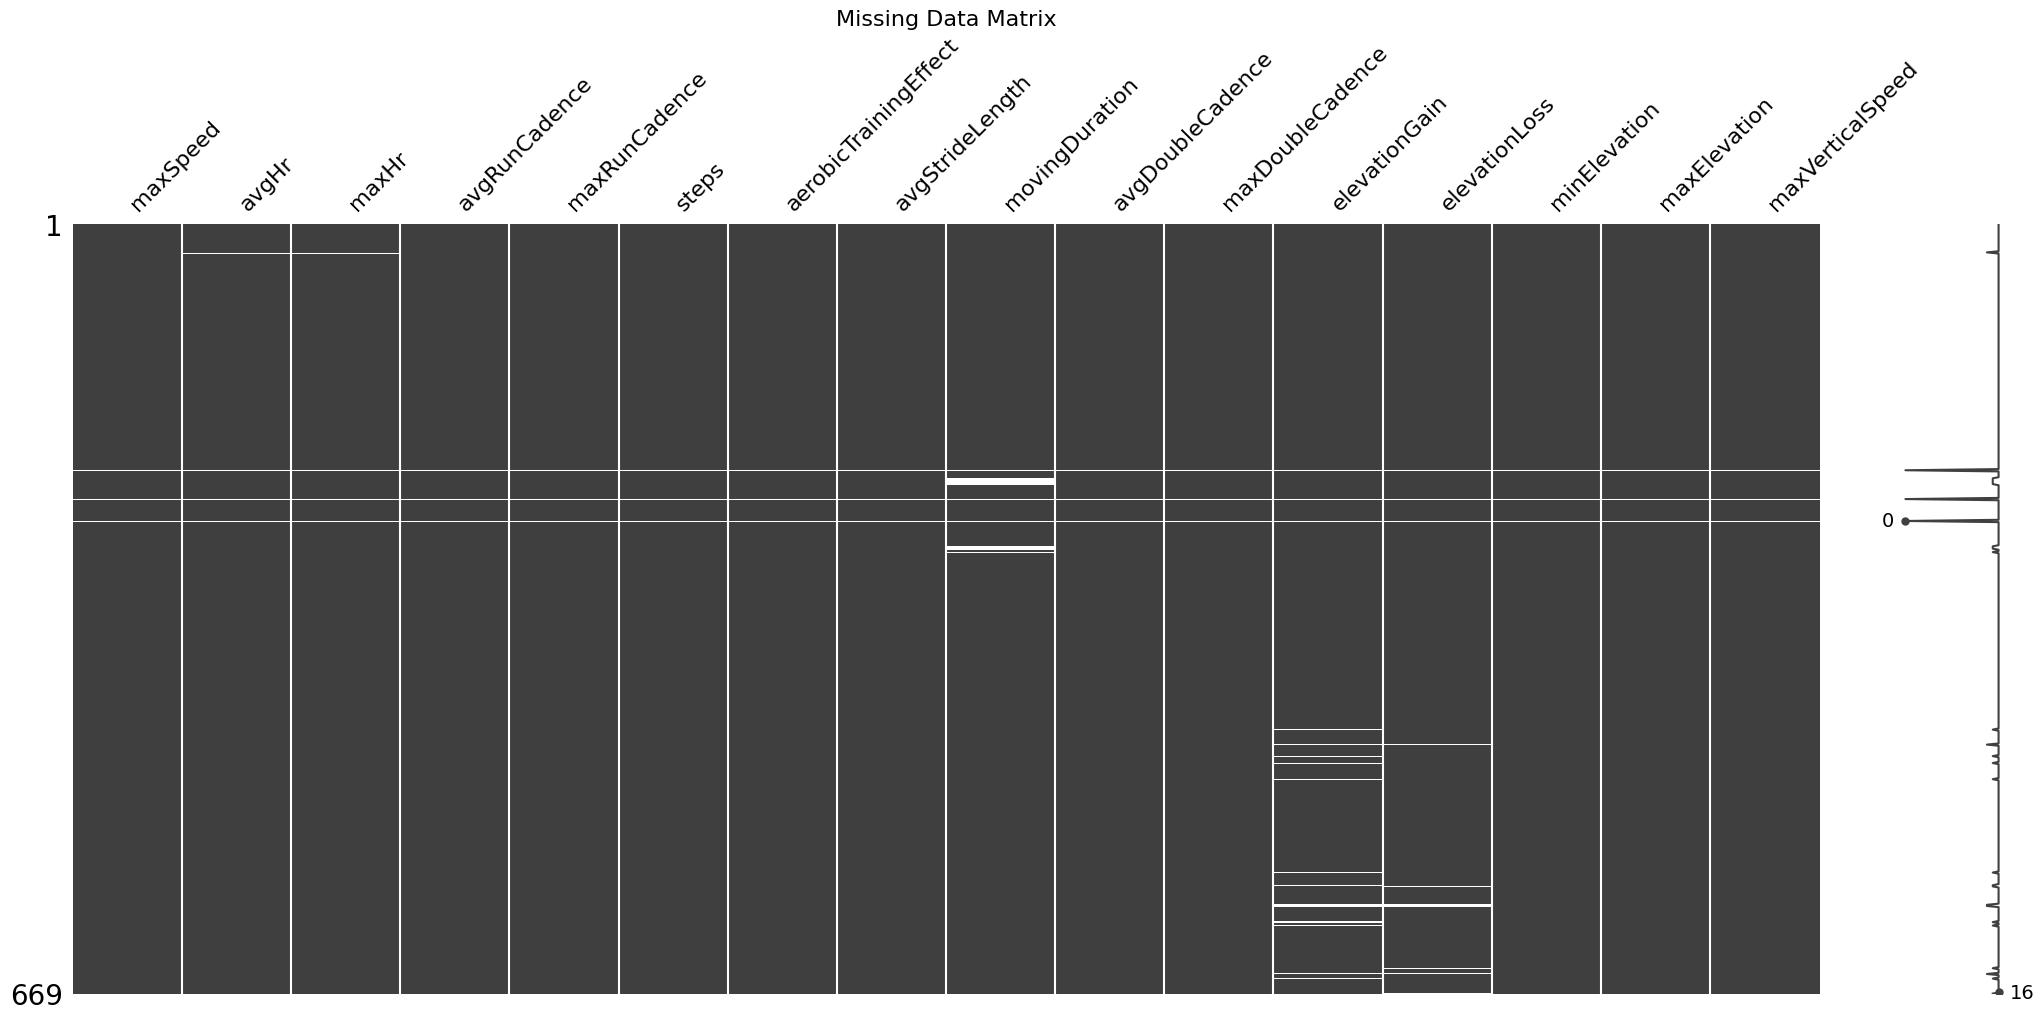

In [19]:
msno.matrix(df_run_missing)
plt.title('Missing Data Matrix', fontsize = 16)
plt.show()

There are clearly 3 rows that are missing information across all of the columns that have missing information. With it being a small proportion of the overall dataset, it's safe to just drop these records from the dataset.

In [20]:
df_run_drp_rows = df_run_cols.dropna(how='all', subset=df_run_missing.columns)
#check new count of records
print("Updated Number of Rows: ", len(df_run_drp_rows))
print("Updated Number of Columns: ", len(df_run_drp_rows.columns))

Updated Number of Rows:  666
Updated Number of Columns:  24


In [21]:
cols_missing_new = df_run_drp_rows.columns[df_run_drp_rows.isnull().any()]
df_run_missing_new = df_run_drp_rows[cols_missing_new]
percent_missing_new = (df_run_missing_new.isnull().sum() / len(df_run_drp_rows)) * 100

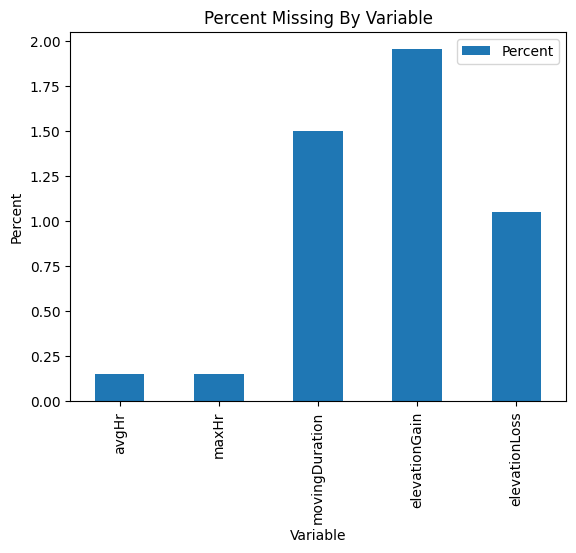

In [22]:
df_pct_missing_new = percent_missing_new.reset_index(name='Percent')

df_pct_missing_new.plot(x='index', y='Percent', kind='bar', title='Percent Missing By Variable')
plt.xlabel('Variable')
plt.ylabel('Percent')
plt.show()


After dropping the 3 records, I can see I've gone from 16 columns with missing data to only 5, which is a much more manageable number. Now that the missing values columns have been narrowed, I am ready to perform imputation.

### Imputing

To determine which kind of imputation to perform, I'm going to look at the distributions of each of the remaining missing columns.

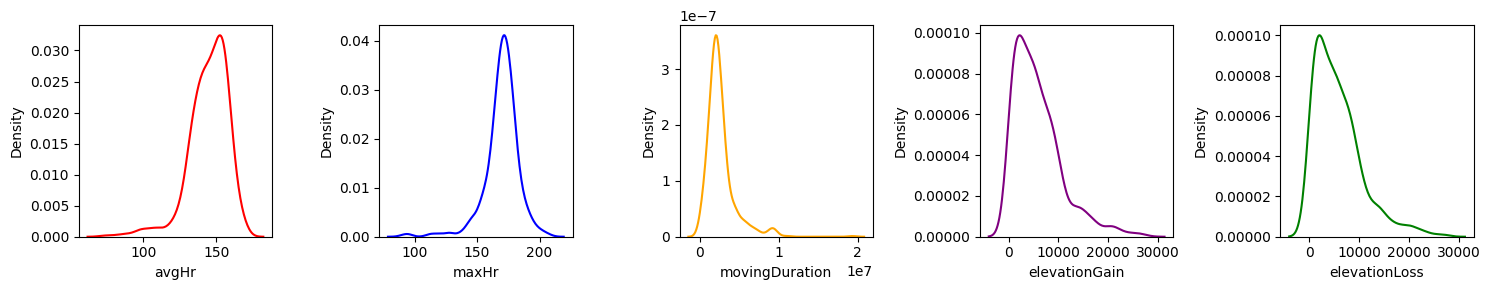

In [23]:
col_avgHr = df_run_drp_rows['avgHr'].dropna()
col_maxHr = df_run_drp_rows['maxHr'].dropna()
col_movingDur = df_run_drp_rows['movingDuration'].dropna()
col_elevationGain = df_run_drp_rows['elevationGain'].dropna()
col_elevationLoss = df_run_drp_rows['elevationLoss'].dropna()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
sns.kdeplot(col_avgHr, ax=axes[0], color='red')
sns.kdeplot(col_maxHr, ax=axes[1], color='blue')
sns.kdeplot(col_movingDur, ax=axes[2], color='orange')
sns.kdeplot(col_elevationGain, ax=axes[3], color='purple')
sns.kdeplot(col_elevationLoss, ax=axes[4], color='green')
plt.tight_layout()
plt.show()

In [24]:
df_run_impute = df_run_drp_rows.copy()

It's clear looking at the distributions that they are skewed and because of this, it makes more sense to impute the missing values using the median instead of the mean. 

In [25]:
cols_impute = ['avgHr','maxHr','movingDuration', 'elevationGain','elevationLoss']

for col in cols_impute:
    df_run_impute[col] = df_run_impute[col].fillna(df_run_impute[col].median())

In [26]:
df_run_impute.head()

,beginTimestamp,startTimeLocal,duration,distance,avgSpeed,maxSpeed,avgHr,maxHr,avgRunCadence,maxRunCadence,...,maxFractionalCadence,elapsedDuration,movingDuration,avgDoubleCadence,maxDoubleCadence,elevationGain,elevationLoss,minElevation,maxElevation,maxVerticalSpeed
23,1734291909000,1.734270e+12,3.601986e+06,830795.019531,0.2306,0.3564,142.0,162.0,76.0,122.0,...,0.0,3.619962e+06,3.584747e+06,153.203125,244.0,11049.000001,10386.000001,15039.999390,18560.000610,0.080000
30,1733845591000,1.733824e+12,2.703300e+06,594897.021484,0.2201,0.3340,132.0,165.0,69.0,123.0,...,0.5,2.710447e+06,2.683775e+06,138.953125,247.0,9993.000001,9913.000000,15280.000305,18419.999695,0.080000
31,1733758718000,1.733737e+12,1.338743e+06,324370.996094,0.2423,0.3611,140.0,164.0,79.0,92.0,...,0.5,1.338743e+06,1.335089e+06,159.093750,185.0,2644.000000,2770.999998,15719.999695,17860.000610,0.026667
48,1732991144000,1.732970e+12,2.805068e+06,644535.009766,0.2298,0.2958,143.0,165.0,78.0,125.0,...,0.0,2.805068e+06,2.792107e+06,156.187500,250.0,11038.000000,11531.999999,15019.999695,20600.000000,0.140001
59,1732545509000,1.732524e+12,3.114505e+06,646908.007812,0.2077,0.2865,134.0,166.0,70.0,125.0,...,0.0,3.213837e+06,3.107182e+06,141.750000,250.0,10400.000000,10662.000000,15439.999390,20639.999390,0.120000


## Identify Column Types and Conversions

Now that there are no longer missing values, I'm going to check the data types for each column and convert them to the appropriate types as needed. I'm also going to ensure that the fields are in forms that make sense to me and will convert metrics to the imperial system if needed.

In [27]:
# Check Data Types of Each Column
df_run_impute.dtypes

beginTimestamp             int64
startTimeLocal           float64
duration                 float64
distance                 float64
avgSpeed                 float64
maxSpeed                 float64
avgHr                    float64
maxHr                    float64
avgRunCadence            float64
maxRunCadence            float64
steps                    float64
aerobicTrainingEffect    float64
avgStrideLength          float64
avgFractionalCadence     float64
maxFractionalCadence     float64
elapsedDuration          float64
movingDuration           float64
avgDoubleCadence         float64
maxDoubleCadence         float64
elevationGain            float64
elevationLoss            float64
minElevation             float64
maxElevation             float64
maxVerticalSpeed         float64
dtype: object

In [28]:
df_run_impute.head()

,beginTimestamp,startTimeLocal,duration,distance,avgSpeed,maxSpeed,avgHr,maxHr,avgRunCadence,maxRunCadence,...,maxFractionalCadence,elapsedDuration,movingDuration,avgDoubleCadence,maxDoubleCadence,elevationGain,elevationLoss,minElevation,maxElevation,maxVerticalSpeed
23,1734291909000,1.734270e+12,3.601986e+06,830795.019531,0.2306,0.3564,142.0,162.0,76.0,122.0,...,0.0,3.619962e+06,3.584747e+06,153.203125,244.0,11049.000001,10386.000001,15039.999390,18560.000610,0.080000
30,1733845591000,1.733824e+12,2.703300e+06,594897.021484,0.2201,0.3340,132.0,165.0,69.0,123.0,...,0.5,2.710447e+06,2.683775e+06,138.953125,247.0,9993.000001,9913.000000,15280.000305,18419.999695,0.080000
31,1733758718000,1.733737e+12,1.338743e+06,324370.996094,0.2423,0.3611,140.0,164.0,79.0,92.0,...,0.5,1.338743e+06,1.335089e+06,159.093750,185.0,2644.000000,2770.999998,15719.999695,17860.000610,0.026667
48,1732991144000,1.732970e+12,2.805068e+06,644535.009766,0.2298,0.2958,143.0,165.0,78.0,125.0,...,0.0,2.805068e+06,2.792107e+06,156.187500,250.0,11038.000000,11531.999999,15019.999695,20600.000000,0.140001
59,1732545509000,1.732524e+12,3.114505e+06,646908.007812,0.2077,0.2865,134.0,166.0,70.0,125.0,...,0.0,3.213837e+06,3.107182e+06,141.750000,250.0,10400.000000,10662.000000,15439.999390,20639.999390,0.120000


In [29]:
#Convert Date/Times 
df_run_impute['beginTimestamp'] = pd.to_datetime(df_run_impute['beginTimestamp'], unit = 'ms')
df_run_impute['startTimeLocal'] = pd.to_datetime(df_run_impute['startTimeLocal'], unit = 'ms')

In [30]:
#Convert Duration
df_run_impute['durationMins'] = (df_run_impute['duration']/1000) /60

In [31]:
#Convert Distance to Miles
df_run_impute['distanceMiles'] = df_run_impute['distance']/ 100/ 1609.344

In [32]:
#Convert to Min/Mile
df_run_impute['avgSpeedMinMile'] = 26.8224 / (df_run_impute['avgSpeed']*10)
df_run_impute['maxSpeedMinMile'] = 26.8224 / (df_run_impute['maxSpeed']*10)

In [33]:
#Convert avgStrideLength
df_run_impute['avgStrideLengthMeters'] = df_run_impute['avgStrideLength']/100

In [34]:
#Convert elapsed and moving duration
df_run_impute['elapsedDurationMins'] = (df_run_impute['elapsedDuration']/1000) /60
df_run_impute['movingDurationMins'] = (df_run_impute['movingDuration']/1000) /60


In [35]:
#Convert Elevation to Feet
df_run_impute['elevationGainFeet'] = df_run_impute['elevationGain']/100 * 3.28084
df_run_impute['elevationLossFeet'] = df_run_impute['elevationLoss']/100 * 3.28084
df_run_impute['minElevationFeet'] = df_run_impute['minElevation']/100 * 3.28084
df_run_impute['maxElevationFeet'] = df_run_impute['maxElevation']/100 * 3.28084


In [36]:
#Convert Max Vertical Speed
df_run_impute['maxVerticalSpeedFtMin'] = df_run_impute['maxVerticalSpeed']* 60 * 3.28084


In [37]:
print(df_run_impute.columns)

Index(['beginTimestamp', 'startTimeLocal', 'duration', 'distance', 'avgSpeed',
       'maxSpeed', 'avgHr', 'maxHr', 'avgRunCadence', 'maxRunCadence', 'steps',
       'aerobicTrainingEffect', 'avgStrideLength', 'avgFractionalCadence',
       'maxFractionalCadence', 'elapsedDuration', 'movingDuration',
       'avgDoubleCadence', 'maxDoubleCadence', 'elevationGain',
       'elevationLoss', 'minElevation', 'maxElevation', 'maxVerticalSpeed',
       'durationMins', 'distanceMiles', 'avgSpeedMinMile', 'maxSpeedMinMile',
       'avgStrideLengthMeters', 'elapsedDurationMins', 'movingDurationMins',
       'elevationGainFeet', 'elevationLossFeet', 'minElevationFeet',
       'maxElevationFeet', 'maxVerticalSpeedFtMin'],
      dtype='object')


In [38]:
#Split the data to imperial version
imperial_cols = ['beginTimestamp', 'startTimeLocal', 'durationMins', 'distanceMiles','avgSpeedMinMile', 'maxSpeedMinMile',
                'avgHr', 'maxHr','avgRunCadence', 'maxRunCadence', 'steps', 'aerobicTrainingEffect', 'avgStrideLengthMeters',
                'avgFractionalCadence','maxFractionalCadence', 'elapsedDurationMins', 'movingDurationMins', 'avgDoubleCadence', 
                 'maxDoubleCadence', 'elevationGainFeet', 'elevationLossFeet', 'minElevationFeet','maxElevationFeet', 
                 'maxVerticalSpeedFtMin']

run_imperial = df_run_impute[imperial_cols]

In [39]:
print("Columns in Imperial: " ,len(run_imperial.columns), " and Rows in Imperial: " ,len(run_imperial))

Columns in Imperial:  24  and Rows in Imperial:  666


### Checking for Outliers

Now that the metrics are converted and in a form that I better understand, I'm going to check for values that may not be reasonable.

In [40]:
run_imperial.describe()

,beginTimestamp,startTimeLocal,durationMins,distanceMiles,avgSpeedMinMile,maxSpeedMinMile,avgHr,maxHr,avgRunCadence,maxRunCadence,...,maxFractionalCadence,elapsedDurationMins,movingDurationMins,avgDoubleCadence,maxDoubleCadence,elevationGainFeet,elevationLossFeet,minElevationFeet,maxElevationFeet,maxVerticalSpeedFtMin
count,666,666,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,...,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,2021-05-06 13:18:59.635135232,2021-05-06 08:00:20.716216064,44.475130,3.654204,12.589153,9.283703,144.678679,169.714715,75.123123,103.822823,...,0.258258,45.173994,43.559219,151.226516,208.162162,191.908712,191.909436,505.902005,592.681747,14.452189
min,2017-05-17 11:34:31,2017-05-17 06:34:31,0.823117,0.055930,8.791347,1.100993,73.000000,90.000000,43.000000,59.000000,...,0.000000,0.823117,0.800000,86.531250,118.000000,0.000000,0.000000,-37.401575,15.748033,0.643993
25%,2019-08-01 10:10:20.249999872,2019-08-01 05:10:20.249999872,26.706034,2.088840,11.187655,8.607959,138.000000,165.000000,73.000000,86.000000,...,0.000000,27.270367,26.855267,146.710938,172.000000,68.930448,67.362224,475.721800,556.480308,5.829776
50%,2021-03-30 23:42:22,2021-03-30 18:42:22,36.449841,3.010879,11.915771,9.242729,147.000000,171.000000,77.000000,112.000000,...,0.500000,36.699384,36.208817,154.203125,224.500000,159.007876,161.286094,508.562915,595.144356,7.888013
75%,2023-03-29 21:53:09.249999872,2023-03-29 16:53:09.249999872,50.617128,4.009893,12.662528,9.843083,154.000000,177.000000,79.000000,121.000000,...,0.500000,51.252478,49.695833,159.089844,243.000000,265.668242,268.774615,522.309718,622.211311,14.615522
max,2024-12-15 19:45:09,2024-12-15 13:45:09,322.309928,26.378263,140.431414,19.824390,171.000000,208.000000,84.000000,125.000000,...,0.500000,322.309928,322.006668,169.968750,250.000000,896.095829,894.521026,928.383304,1183.413346,523.622184
std,NaN,NaN,32.923484,2.666615,6.785070,1.756265,13.663476,13.799847,5.802502,17.629397,...,0.250051,33.568384,30.504803,11.582502,35.255597,160.066829,158.865897,73.566646,83.053080,29.953098


In [41]:
run_imperial[run_imperial['avgSpeedMinMile']>30]

,beginTimestamp,startTimeLocal,durationMins,distanceMiles,avgSpeedMinMile,maxSpeedMinMile,avgHr,maxHr,avgRunCadence,maxRunCadence,...,maxFractionalCadence,elapsedDurationMins,movingDurationMins,avgDoubleCadence,maxDoubleCadence,elevationGainFeet,elevationLossFeet,minElevationFeet,maxElevationFeet,maxVerticalSpeedFtMin
2264,2018-06-19 22:35:46,2018-06-19 17:35:46,9.467683,0.067313,140.431414,19.824390,149.0,171.0,69.0,83.0,...,0.0,14.485500,8.166667,139.796875,166.0,159.007876,161.286094,630.992149,633.857727,0.782088
2265,2018-06-19 22:06:48,2018-06-19 17:06:48,19.613684,0.162321,120.821620,10.890134,110.0,166.0,65.0,80.0,...,0.0,19.613684,6.966667,131.281250,160.0,159.007876,161.286094,631.427535,634.214767,0.643993


It's pretty evident to me that 120 min/mile and 140 min/mile on avg are far oustide the realm of a normal running pace for me and I am going to drop these two records from the dataset.

In [42]:
drop_rows = [2264, 2265]

df_run_imperial = run_imperial.drop(drop_rows)

In [43]:
df_run_imperial[df_run_imperial['avgSpeedMinMile']>30]

,beginTimestamp,startTimeLocal,durationMins,distanceMiles,avgSpeedMinMile,maxSpeedMinMile,avgHr,maxHr,avgRunCadence,maxRunCadence,...,maxFractionalCadence,elapsedDurationMins,movingDurationMins,avgDoubleCadence,maxDoubleCadence,elevationGainFeet,elevationLossFeet,minElevationFeet,maxElevationFeet,maxVerticalSpeedFtMin


In [44]:
len(df_run_imperial)

664

# EDA

### Univariate & Multivariate Analysis

Using pairplots, I am going to investigate what kind of relationships the predictors have to the respsonse (avgSpeedMinMile), ie are they linear? non-linear? Does there seem to be a strong correlation with any of them?

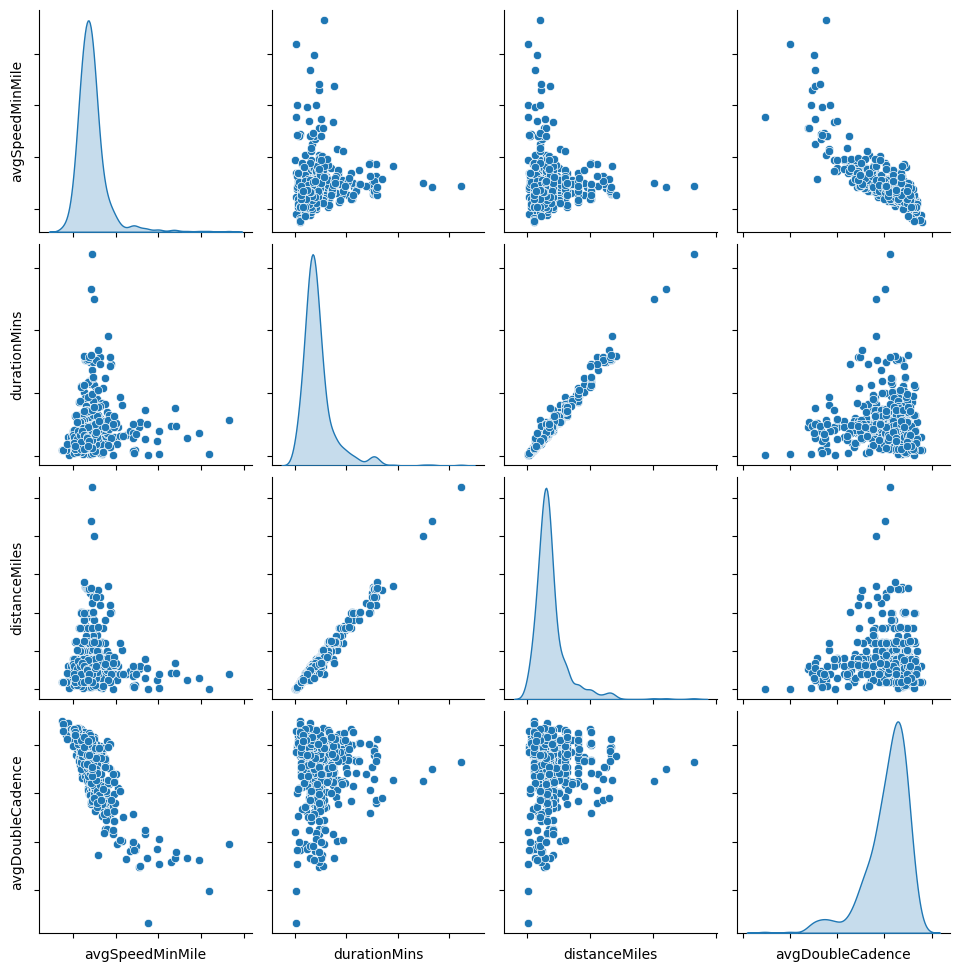

In [45]:
pair_plot_1 = sns.pairplot(df_run_imperial[['avgSpeedMinMile','durationMins','distanceMiles','avgDoubleCadence']], diag_kind = 'kde')
pair_plot_1.set(xticklabels = [], yticklabels = [])
plt.show()

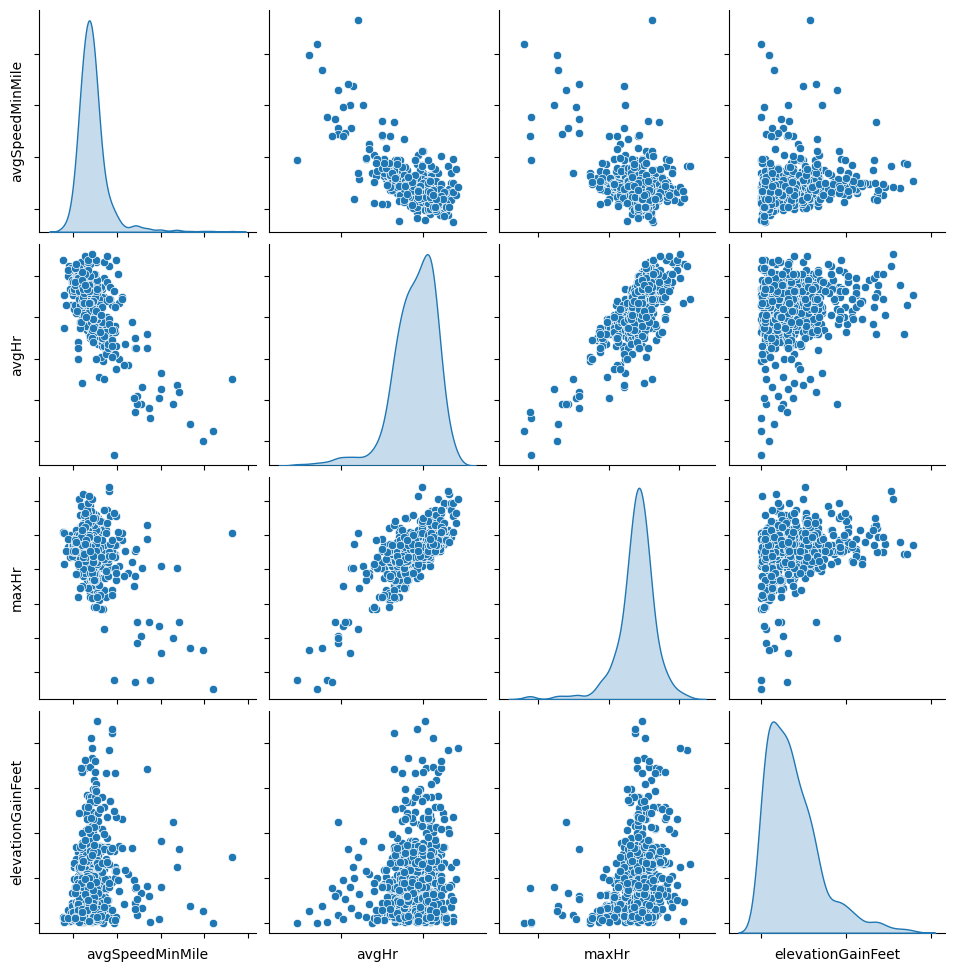

In [46]:
pair_plot_2 = sns.pairplot(df_run_imperial[['avgSpeedMinMile','avgHr','maxHr','elevationGainFeet']], diag_kind = 'kde')
pair_plot_2.set(xticklabels = [], yticklabels = [])
plt.show()

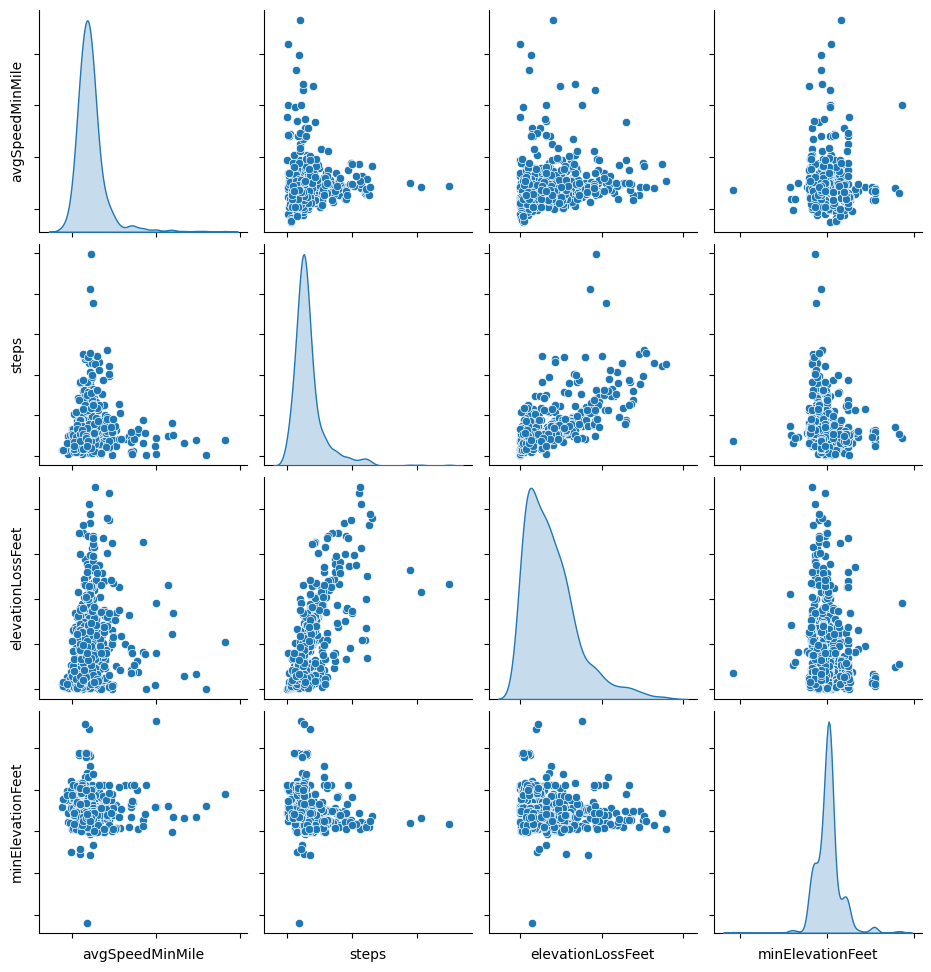

In [47]:
pair_plot_3 = sns.pairplot(df_run_imperial[['avgSpeedMinMile','steps','elevationLossFeet','minElevationFeet']], diag_kind = 'kde')
pair_plot_3.set(xticklabels = [], yticklabels = [])
plt.show()

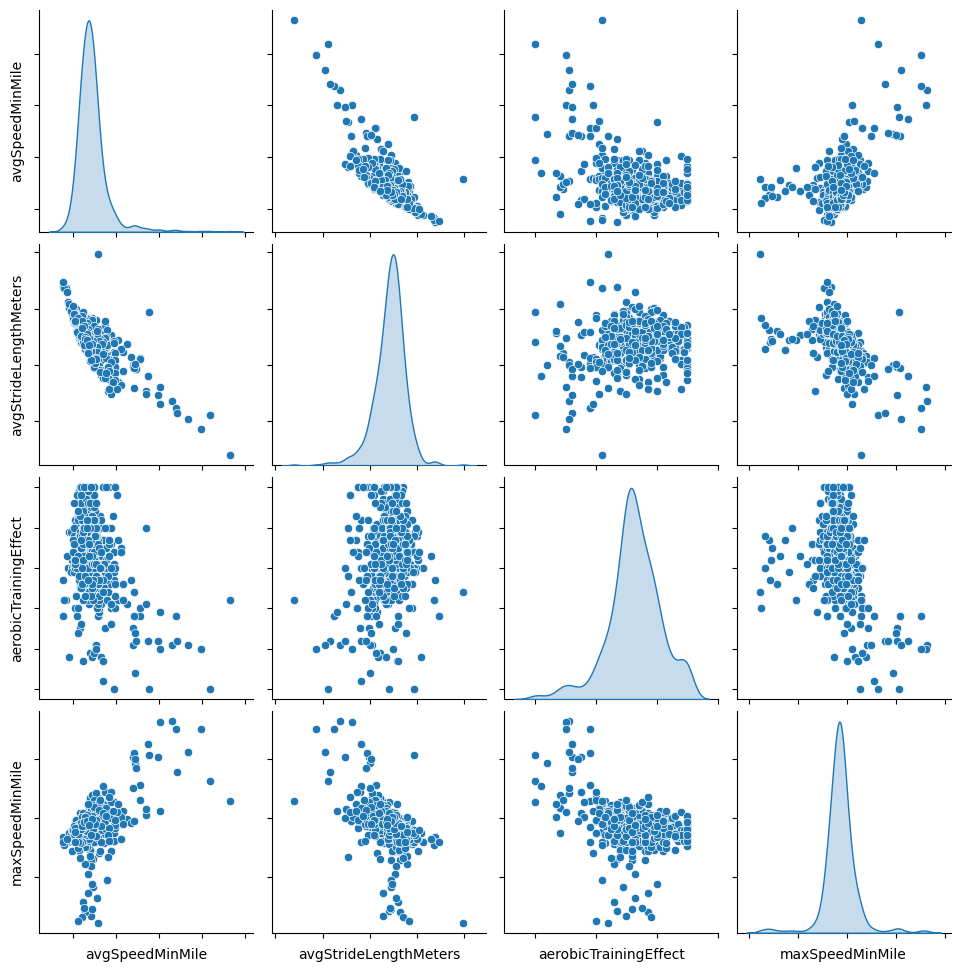

In [48]:
pair_plot_4 = sns.pairplot(df_run_imperial[['avgSpeedMinMile','avgStrideLengthMeters','aerobicTrainingEffect','maxSpeedMinMile']], diag_kind = 'kde')
pair_plot_4.set(xticklabels = [], yticklabels = [])
plt.show()

In [49]:
df_continuous = df_run_imperial.select_dtypes(include=np.number)

skew_values = df_continuous.apply(stats.skew)
df_skew_values = skew_values.to_frame(name='Skewness')
df_skew_values['Skew Type'] = np.where(df_skew_values['Skewness'] > 0.5, 'Right', np.where(df_skew_values['Skewness'] < -0.5, 'Left', 'Approx. Normal'))

grouped_skewness = df_skew_values.groupby('Skew Type').size().reset_index(name='Count')
print(df_skew_values[df_skew_values['Skew Type'] == 'Right'])
print(df_skew_values[df_skew_values['Skew Type'] == 'Left'])
print(df_skew_values[df_skew_values['Skew Type'] == 'Approx. Normal'])

                        Skewness Skew Type
durationMins            2.998929     Right
distanceMiles           3.007765     Right
avgSpeedMinMile         3.398743     Right
steps                   3.039096     Right
elapsedDurationMins     3.054773     Right
movingDurationMins      2.754945     Right
elevationGainFeet       1.435704     Right
elevationLossFeet       1.389713     Right
minElevationFeet        0.706210     Right
maxVerticalSpeedFtMin  11.432021     Right
                       Skewness Skew Type
avgHr                 -1.389748      Left
maxHr                 -1.655353      Left
avgRunCadence         -1.615174      Left
aerobicTrainingEffect -0.535237      Left
avgStrideLengthMeters -0.940091      Left
avgDoubleCadence      -1.614445      Left
                      Skewness       Skew Type
maxSpeedMinMile       0.072738  Approx. Normal
maxRunCadence        -0.205601  Approx. Normal
avgFractionalCadence  0.048642  Approx. Normal
maxFractionalCadence -0.072336  Approx. Norma

Based on the pairplots, I can see that many of the variables are right skewed, including avgSpeedMinMile. This makes sense in that I'm generally going to have runs that are at what would be considered a running pace (on the low end of the distribution), but it's not out of the realm of possiblity to have ones that are more of a walking pace (on the high end of the distribution). Likewise with distance, I'm usually running shorter distances, but there have been occasions, like when I'm training for a half or full marathon, where I'd be running longer distances that result in the right skewed data I'm seeing.

When looking at the relationships between the response (avgSpeedMinMile) and the potential predictors, AvgHr, avgStrideLengthMeters, and avgDoubleCadence seem to have the strongest relationship with avgSpeedMinMile.

### Correlation Matrix

To further explore the relationship between the predictors, I'm going to build a correlation matrix. My goal with this is to understand how they interact with each other (if at all). Based on what I know about the data, my suspicions are that there are a couple features that may be scalers of another.

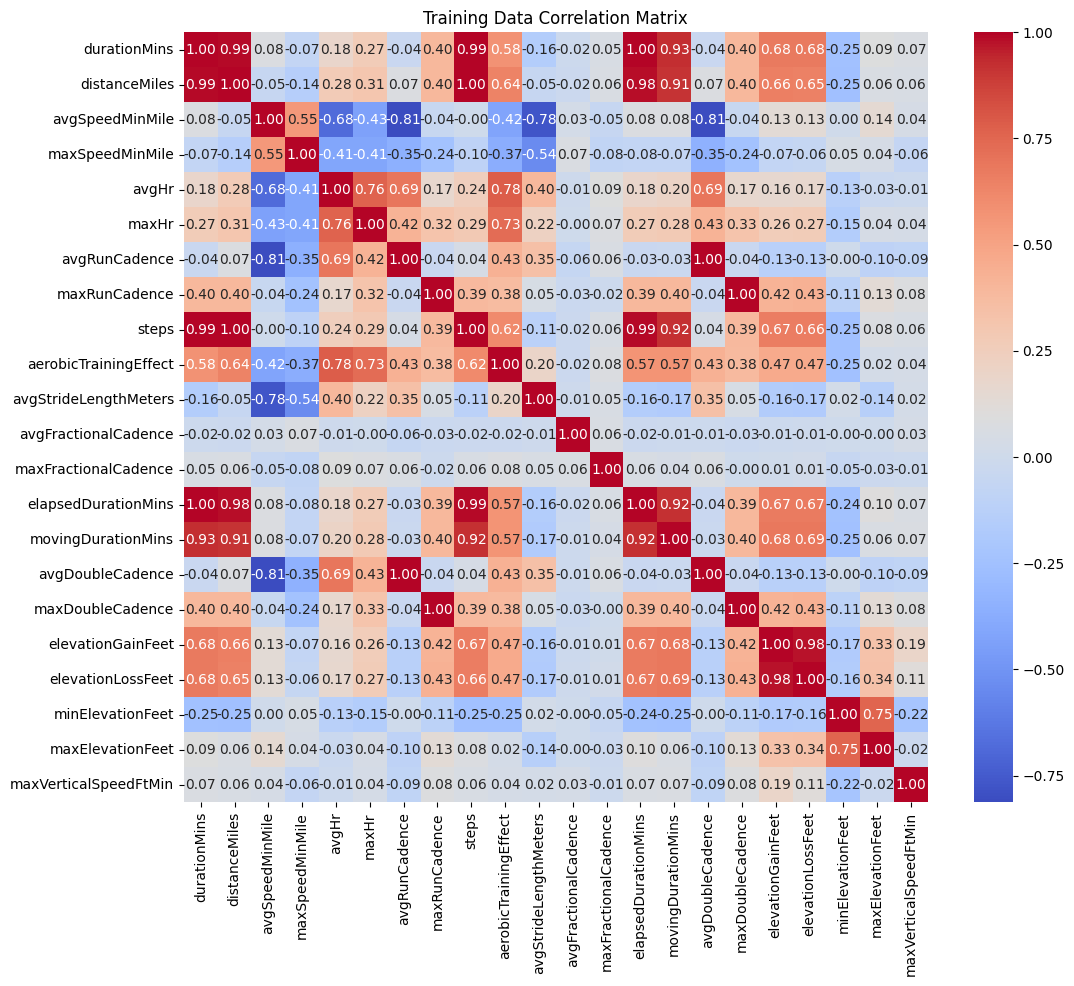

In [50]:
corr_matrix = df_run_imperial.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Training Data Correlation Matrix')
plt.show()

# Model Building

## Decision Tree Regressor

Based on the relationships between the response and the predictors (non-linear in many cases) and the fact that there appears to be some highly correlated variables, I am going to start by builiding a decision tree regressor. Since I am not using a linear regression, I do not need to transform or deal with the collinearity of variables. 

### Encode Day of the Week

Encode day of the week using cycle encoding to ensure the relationship between Sunday-Monday is maintained. If I had left it 1 to 7 for Monday to Sunday, this would assume Monday was farther away from Sunday than it is from Tuesday which is not correct. Since running back to back days could effect my overall running pace, I felt it was important to ensure I accurately modeled the day of the week relationship.

In [51]:
#Transform Variable to DOW Number
df_run_imperial['dayOfWeek'] = df_run_imperial['startTimeLocal'].dt.dayofweek + 1

In [52]:
#df_run_imperial['DOWEncode'] 
df_run_imperial['dayOfWeekSin'] = np.sin(df_run_imperial['dayOfWeek'] * (2 * np.pi / 7))
df_run_imperial['dayOfWeekCosine'] = np.cos(df_run_imperial['dayOfWeek'] * (2 * np.pi / 7))


In [53]:
df_run_imperial = df_run_imperial.drop(['beginTimestamp','startTimeLocal', 'dayOfWeek'], axis = 1)

### Split the Model into Training and Testing 
I did a standard 80/20 split on the data. 80% for training and 20% for testing and fit a decision tree regressor to the model.

In [54]:
#Split the metric and imperial versions into testing and training before feature selection/correlations
X = df_run_imperial.drop('avgSpeedMinMile', axis=1)
y = df_run_imperial['avgSpeedMinMile']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75) 

In [55]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (531, 23)
X_test shape: (133, 23)
y_train shape: (531,)
y_test shape: (133,)


### Fit the Decision Tree Regressor

In [56]:
regressor = DecisionTreeRegressor(random_state=75)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=75)

In [57]:
print(f"Model Score on Training Data: {regressor.score(X_train, y_train)}")


Model Score on Training Data: 1.0


### Cross Validation

Based on the R-squared score for the regressor, it appears that the model is overfitting. I'm going to check this assumption through cross validation, the results of which will inform my decision around whether to tune the parameters.

In [58]:
cv_scores_reg = cross_val_score(regressor, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R-Sqrd Scores:", cv_scores_reg)
print("Mean CV R-Sqrd:", cv_scores_reg.mean())

Cross-Validation R-Sqrd Scores: [0.97320501 0.88760661 0.91370649 0.93904766 0.82239847]
Mean CV R-Sqrd: 0.907192847103709


Because the resulting scores of the cross validation are not consistent, I'm inclined to believe the model is overfitting and therefore am going to tune some of the hyper parameters.

### Tuning Hyperparameters

I'm going to use the GridSearchCV function to further tune the parameters on my model in an attempt to improve the fit of my model.

In [59]:
parameters = {'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2, 5]}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=75), parameters)
gridSearch.fit(X_train, y_train)

best_regressor = gridSearch.best_estimator_
gridSearch.best_score_
print("Best parameters:", gridSearch.best_params_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2}


In [60]:
print(f"Model Score on Training Data: {best_regressor.score(X_train, y_train)}")


Model Score on Training Data: 0.9939945687614602


### Cross Validation - Best Regressor

Now that I've found the best parameters for the regressor, I'm going to re-run the cross validation and see if that has improved the model's results. The best regressor did bring down the training data score to 0.99, but I want to see if that performance holds.

In [61]:
cv_scores_br = cross_val_score(best_regressor, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R-Sqrd Scores:", cv_scores_br)
print("Mean CV R-Sqrd:", cv_scores_br.mean())

Cross-Validation R-Sqrd Scores: [0.95824219 0.90998015 0.91181636 0.95188822 0.81858451]
Mean CV R-Sqrd: 0.9101022848224982


Choosing the best parameters did slightly improve the performance in cross validation scores, however there is still a wide range, so the model still appears to be overfitting to the data.

### Feature Importance

Because the model is still overfitting, I'm going to look at feature importance and see if feature reduction improves the results in cross validation. 

In [62]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_regressor.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


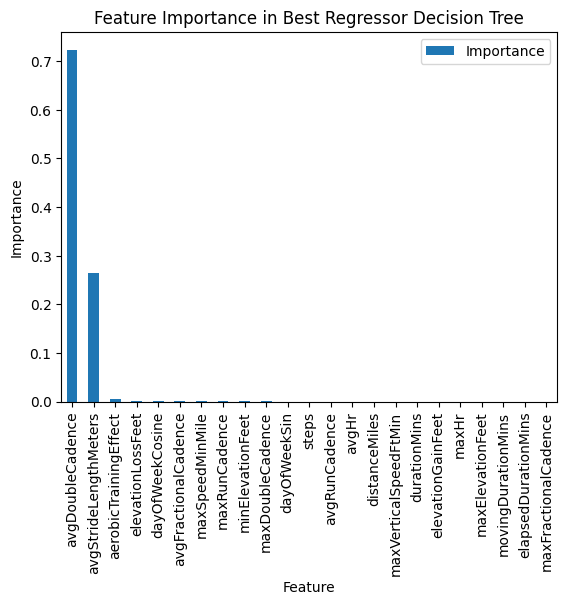

In [63]:
feature_importance.plot(x='Feature', y=['Importance'], kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Best Regressor Decision Tree')

plt.show()

AvgDoubleCadence and avgStrideLengthMeters appear to be relatively important while the other features' importance is almost zero. I'm going to reduce the features to just avgDoubleCadence and avgStrideLengthMeters and refit the best regressor using a reduced training set. Then test the cross validation scores on this set to see if they are improved. 

In [64]:
X_train_red = X_train[['avgDoubleCadence', 'avgStrideLengthMeters']]
best_regressor.fit(X_train_red, y_train)

print(f"Model Score on Training Data: {best_regressor.score(X_train_red, y_train)}")

cv_scores_red = cross_val_score(best_regressor, X_train_red, y_train, cv=5, scoring='r2')
print("Cross-Validation R-Sqrd Scores:", cv_scores_red)
print("Mean CV R-Sqrd:", cv_scores_red.mean())

Model Score on Training Data: 0.9933998357287519
Cross-Validation R-Sqrd Scores: [0.98519729 0.9603903  0.96829872 0.94218547 0.94558452]
Mean CV R-Sqrd: 0.9603312600026754


Feature reduction appears to be the key for getting a generalizable model. Now that I have the reduced model that is performing well in cross validation, I'm going to run the evaluation metrics for the testing data. 

### Evaluate Model Performance on Testing Data

In [65]:
X_test_red = X_test[['avgDoubleCadence', 'avgStrideLengthMeters']]
y_pred_red = best_regressor.predict(X_test_red)

mae_red = mean_absolute_error(y_test, y_pred_red) 
mse_red = mean_squared_error(y_test, y_pred_red)


print("Mean Absolute Error: ", mae_red)
print("Mean Squared Error: ", mse_red)
print(f"Model Score on Training Data: {best_regressor.score(X_train_red, y_train)}")
print(f"Model Score on Testing Data: {best_regressor.score(X_test_red, y_test)}")

Mean Absolute Error:  0.23111034350027967
Mean Squared Error:  0.3154848351213343
Model Score on Training Data: 0.9933998357287519
Model Score on Testing Data: 0.926073918299109


The model performs well for the testing data as well, but I'm curious to see if I can further improve the results with a random forest. 

## Random Forest

### Fit the Random Forest

In [66]:
rand_forest = RandomForestRegressor(random_state = 75)
rand_forest.fit(X_train_red, y_train)

RandomForestRegressor(random_state=75)

In [67]:
print(f"Model Score on Training Data: {rand_forest.score(X_train_red, y_train)}")

Model Score on Training Data: 0.9949792726204726


### Cross Validation on Training Set

In [68]:
cv_scores_rf = cross_val_score(rand_forest, X_train_red, y_train, cv=5, scoring='r2')
print("Random Forest Cross-Validation R-Squared Scores:", cv_scores_rf)
print("Mean CV R-Squared:", cv_scores_rf.mean())

Random Forest Cross-Validation R-Squared Scores: [0.9821024  0.99029692 0.98261153 0.97749361 0.90819555]
Mean CV R-Squared: 0.9681400032612609


The cross validation scores look pretty good, but I'm still going to tune the hyperparameters to see if I can improve the fit. 

### Tuning Hyperparameters

In [69]:
parameters_rf = {'max_depth': [10,20, None], 'min_samples_leaf': [1, 2, 5], 'min_samples_split' : [2, 5, 10], 'n_estimators' : [50, 100, 200]}
gridSearch_rf = GridSearchCV(RandomForestRegressor(random_state=75), parameters_rf)
gridSearch_rf.fit(X_train_red, y_train)

best_regressor_rf = gridSearch_rf.best_estimator_
gridSearch_rf.best_score_
print("Best parameters:", gridSearch_rf.best_params_)
print(f"Model Score on Training Data: {best_regressor_rf.score(X_train_red, y_train)}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Model Score on Training Data: 0.995121120780537


### Cross Validation on Training Set with Best Regressor

In [70]:
cv_scores_rfbr = cross_val_score(best_regressor_rf, X_train_red, y_train, cv=5, scoring='r2')
print("Random Forest Cross-Validation R-Squared Scores:", cv_scores_rfbr)
print("Mean CV R-Squared:", cv_scores_rfbr.mean())

Random Forest Cross-Validation R-Squared Scores: [0.98102894 0.99204153 0.97908766 0.97920848 0.91839596]
Mean CV R-Squared: 0.9699525160134496


Tuning the parameters did slightly improve the cross-validation scores and they are fairly stable, so I'm going to evaluate the performance on the testing data.

### Evaluate Model Performance  

In [71]:
y_pred_rf = best_regressor_rf.predict(X_test_red)
mae_rf = mean_absolute_error(y_test, y_pred_rf) 
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Mean Absolute Error: ", mae_rf)
print("Mean Square Error: ", mse_rf)
print(f"Model Score on Training Data: {best_regressor_rf.score(X_train_red, y_train)}")
print(f"Model Score on Testing Data: {best_regressor_rf.score(X_test_red, y_test)}")

Mean Absolute Error:  0.14847568971709507
Mean Square Error:  0.24065504339084684
Model Score on Training Data: 0.995121120780537
Model Score on Testing Data: 0.9436084324224301


When compared to the decision tree, the random forest improved the overall performance on the testing data by further lowering MSE and increasing R-squared for the testing data.

## Model Comparisons 

### Comparing Improvements in CV Scores

Each iteration improved the CV scores variability as well as it's overall mean score. Making it evident that the tuning of parameters and dropping of features improved the model's performance.

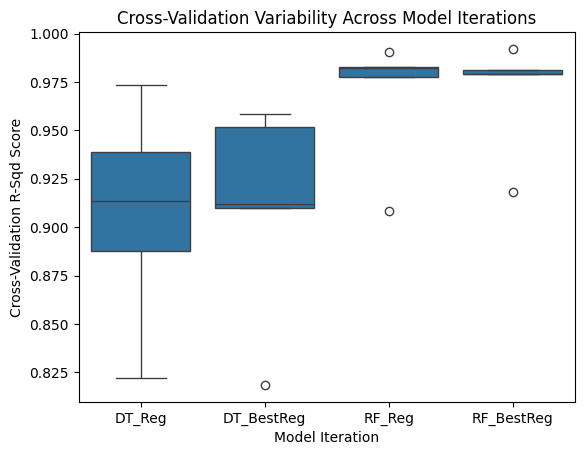

In [72]:
df_cv = pd.DataFrame(list(zip(cv_scores_reg, cv_scores_br, cv_scores_rf, cv_scores_rfbr)), columns = ['DT_Reg', 'DT_BestReg','RF_Reg','RF_BestReg'])
df_cv['K_Fold'] = [1, 2, 3, 4, 5]

df_cv_melted = df_cv.melt(id_vars=['K_Fold'], var_name='Model', value_name='R-Sqd Score')

sns.boxplot(x='Model', y='R-Sqd Score', data=df_cv_melted)

plt.xlabel("Model Iteration")
plt.ylabel("Cross-Validation R-Sqd Score")
plt.title("Cross-Validation Variability Across Model Iterations")
plt.show()

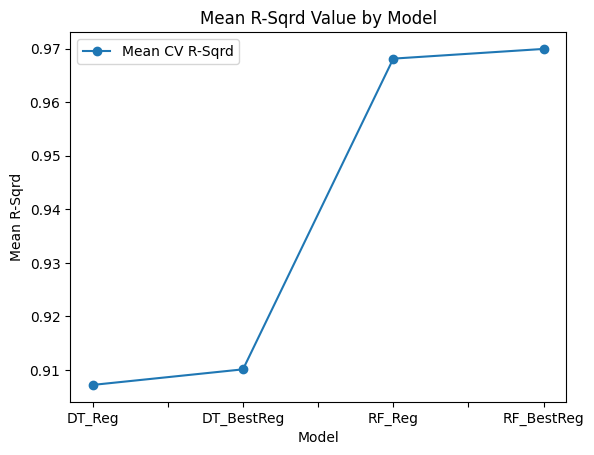

In [73]:
mean_values = [cv_scores_reg.mean(),cv_scores_br.mean(), cv_scores_rf.mean(),cv_scores_rfbr.mean()]
model = ['DT_Reg', 'DT_BestReg','RF_Reg','RF_BestReg']
df_mean_cv = pd.DataFrame(list(zip(model, mean_values)), columns = ['Model', 'Mean CV R-Sqrd'])

df_mean_cv.plot(x='Model', y='Mean CV R-Sqrd', marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Mean R-Sqrd')
plt.title('Mean R-Sqrd Value by Model')
plt.show()
                          

### Comparing MSE & R-squared

In [74]:
r2_dt = r2_score(y_test, y_pred_red)
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error Random Forest: ", mse_rf)
print("Mean Squared Error Decision Tree: ", mse_red)
print("R-Squared Random Forest: ", r2_rf)
print("R-Squared Decision Tree: ", r2_dt)


Mean Squared Error Random Forest:  0.24065504339084684
Mean Squared Error Decision Tree:  0.3154848351213343
R-Squared Random Forest:  0.9436084324224301
R-Squared Decision Tree:  0.926073918299109


The Random Forest outperformed the Decision Tree which is evidenced in its slightly higher R-squared and lower MSE. 